In [40]:
import math
import scipy
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import genpareto
from scipy.stats import t as studentt
from scipy.stats import gumbel_r as gumbel
from statistics import mean
from scipy.optimize import minimize
from scipy import signal

import paramonte as pm
import seaborn as sns

In [41]:
# Tide gauge data (daily max data) - Woods Hole, MA, USA
wh_tg = pd.read_excel("WH_DailyMaxTG.xlsx", sheet_name = "WHDailyMaxTG")

# Overwash data from Mattapoisett Marsh, MA, USA
mm_od = pd.read_excel("WH_DailyMaxTG.xlsx", sheet_name = "MM_OE")

wh_tg_t = wh_tg['Time'] # Woods Hole TG time
wh_tg_h = wh_tg['Max_Tide'] # Woods Hole TG water levels
# print(mean(wh_tg_h))
wh_tg_h = signal.detrend(wh_tg_h, type == 'constant')

od_t = mm_od['meanYCE'] # mean ages of MM overwash deposits
# num_od = len(od_t) # number of overwash deposits in MM record

num_od = 30 # number of overwash deposits that do no overlap with tide gauge record

In [42]:
df, loc, scale = studentt.fit(wh_tg_h)

print(df, loc, scale)

9.212540751289186 -2.060336162949713 148.3135546178534


434.2776897968916


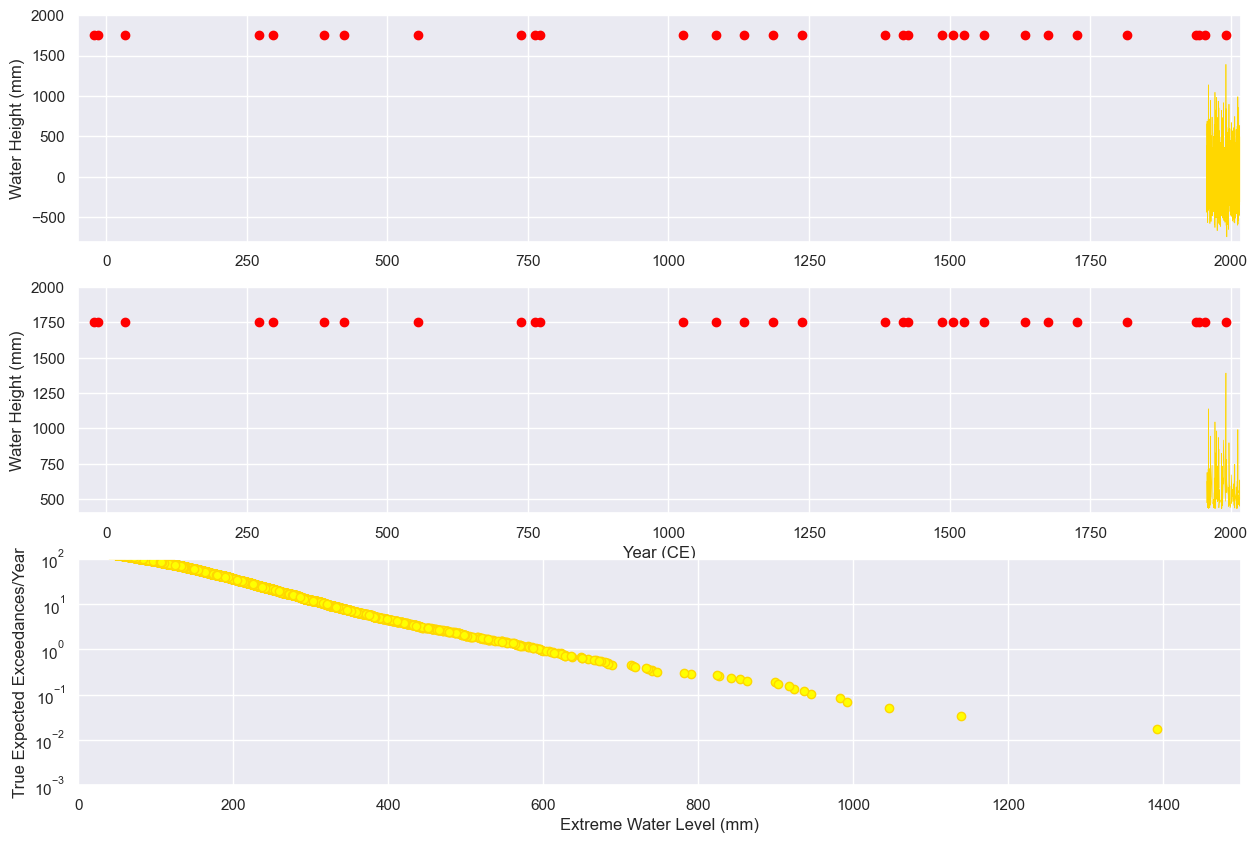

In [43]:
fig = plt.figure(figsize=(15,10))

# Woods Hole, MA tide gauge record (1957-2016 CE)
ax = fig.add_subplot(311)
plt.plot(wh_tg_t, wh_tg_h, linewidth = 0.5, color = 'gold')
y = np.full((1,31), 1750)
plt.scatter(od_t, y, color = 'red')

ax.set_xlim(-50,2018)
ax.set_ylim(-800,2000)
plt.ylabel('Water Height (mm)', fontsize = 12)

# 99th percentile of Woods Hole tide gauge record (1957-2016 CE)
q99 = np.quantile(wh_tg_h, 0.99)
print(q99)
wh_tg_h99 = wh_tg_h[(wh_tg_h >= q99)]
wh_tg_t99 = wh_tg_t[(wh_tg_h >= q99)]

ax2 = fig.add_subplot(312)
plt.plot(wh_tg_t99, wh_tg_h99, linewidth = 0.5, color = 'gold')
plt.scatter(od_t, y, color = 'red')

x1 = [-100, 2020]
y1 = [1448, 1448]

# plt.plot(x1,y1, color = 'orangered')

ax2.set_xlim(-50,2018)
ax2.set_ylim(400,2000)
plt.xlabel('Year (CE)', fontsize = 12)
plt.ylabel('Water Height (mm)', fontsize = 12)

# Empirical return curve & modeled return curve from Student's t distribution
#   based on Woods Hole tide gauge

ax3 = fig.add_subplot(313)

testexca = list(np.arange(-500.0, 1500.0, 10.0))
testexcb = wh_tg_h
exceeded_tide = []

for i in range(0, len(testexcb)):
        exctg = sum(wh_tg_h >= testexcb[i])/59.0
        exceeded_tide.append(exctg)
        
trueexc = (studentt.sf(testexca, 9.213, -2.060, 148.3)*365)

plt.scatter(testexcb, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold')
# plt.plot(testexca, trueexc, color = 'slategray')

ax3.set_yscale('log')
ax3.set_xlim([0, 1500])
ax3.set_ylim([1e-3, 1e2])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('True Expected Exceedances/Year', fontsize = 12)
# ax3.legend(["Modeled Curve from Student's t", "Woods Hole Tide Gauge Data"])

plt.savefig("MMandWHData.pdf", bbox_inches = 'tight', dpi = 300)


In [44]:
# define functions to be optimized (log likelihoods)

def function_a(z, parameters): # just a funciton used in both likelihood functions
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    
    return (np.log(1 + (xi * ((z - mu)/phi))))

# negative log likelihood for tide data & proxy data    
def log_likelihood(parameters):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tau = parameters[3]
    tide_threshold = q99 # same as true location parameter
    
    tg_z = wh_tg_h99 # tide gauge water levels from WH
    N = len(tg_z) # number of tide gauge water levels over tide_threshold
    M = num_od # number of overwash deposits in geologic record at MM

    t1 = -50
    t2 = 2018
    t_tide = 1957
    
    ll_geo_tide = ((-1 * N * np.log(phi)) + ((-1 - (1/xi)) * np.sum(function_a(tg_z, parameters))) -
        ((M/xi) * np.log(1 + (xi * ((tau - mu)/phi)))) -
        ((t2 - t_tide) * (1 + ((xi * (q99 - mu))/phi))**(-1/xi)) -
        ((t_tide - t1) * (1 + ((xi * (tau - mu))/phi))**(-1/xi)))
    
    return(ll_geo_tide) 

# negative log likelihood for tide data only
def log_likelihood_tide(parameters):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tide_threshold = q99 # same as true location parameter
    
    tg_z = wh_tg_h99
    N = len(tg_z)
    
    t2 = 2018
    t_tide = 1957 # start of tide gauge record
    
    ll_tide = ((-1 * N * np.log(phi)) +
        ((-1 - (1/xi)) * np.sum(function_a(tg_z, parameters))) -
        ((t2 - t_tide) * (1 + ((xi * (q99 - mu))/phi))**(-1/xi)))
    
    return(ll_tide)


In [45]:
# test negative log likelihood function - testing with true parameter values
parameters_0 = [600, 128.5, 0.188, 1200] # true parameter values
parameters_0tide = [600, 128.5, 0.188]

ans = log_likelihood(parameters_0)
print(ans)

ans1 = log_likelihood_tide(parameters_0tide)
print(ans1)

-1327.155002037076
-1156.307691620533


In [46]:
pmpd_tide = pm.ParaDRAM()

In [47]:
pmpd_tide.spec.overwriteRequested = True # overwrite the existing output files just in case they already exist.
pmpd_tide.spec.outputFileName = "./out/ESL&GS_S_MCMC" # specify the output file prefixes.
pmpd_tide.spec.randomSeed = 12345 # set the random seed for the sake of reproducibity.
pmpd_tide.spec.variableNameList = ["mu", "phi", "xi"] # set the output names of the parameters.
pmpd_tide.spec.chainSize = 20000 # set the number of uniquely sampled points from the likelihood function.
pmpd_tide.spec.domainLowerLimitVec = [400, 100, 1e-10]
pmpd_tide.spec.domainUpperLimitVec = [1000, 500, 1]

In [48]:
pmpd_tide.runSampler( ndim = 3, # the number of parameters
               getLogFunc = log_likelihood_tide # the objective function to sample points from
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                     20000 / 58112             0.3789 / 0.3455             0.8146 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

In [49]:
chain_tide = pmpd_tide.readChain(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readChain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_MCMC*_chain.txt"


ParaDRAM - NOTE: processing chain file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_MCMC_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 0.018365 seconds.
ParaDRAM - NOTE: ndim = 3, count = 20000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating a h

In [50]:
sample_tide = pmpd_tide.readSample(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_MCMC*_sample.txt"


ParaDRAM - NOTE: processing sample file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_MCMC_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.002211 seconds.
ParaDRAM - NOTE: ndim = 3, count = 4083
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating

In [51]:
sample_tide.df.mean()

SampleLogFunc   -1145.606922
mu                592.428388
phi               142.752462
xi                  0.117300
dtype: float64

In [52]:
sample_tide.df.std()

SampleLogFunc     1.302484
mu               16.333761
phi              12.194046
xi                0.071410
dtype: float64

In [53]:
sample_tide.df.quantile([0.05, 0.5, 0.95])

,SampleLogFunc,mu,phi,xi
0.05,-1148.13399,567.129771,124.809065,0.017978
0.50,-1145.25790,591.698940,141.819650,0.108373
0.95,-1144.25187,619.742161,164.555612,0.250061


ParaDRAM - NOTE: making the grid plot... 
generating subplot #1: (0,0) out of 9... done in 0.018883 seconds.
generating subplot #2: (0,1) out of 9... done in 0.101928 seconds.
generating subplot #3: (0,2) out of 9... done in 0.097608 seconds.
generating subplot #4: (1,0) out of 9... done in 0.182073 seconds.
generating subplot #5: (1,1) out of 9... done in 0.018883 seconds.
generating subplot #6: (1,2) out of 9... done in 0.105319 seconds.
generating subplot #7: (2,0) out of 9... done in 0.190325 seconds.
generating subplot #8: (2,1) out of 9... done in 0.174119 seconds.
generating subplot #9: (2,2) out of 9... done in 0.018883 seconds.
generating colorbar... done in 0.009167 seconds.


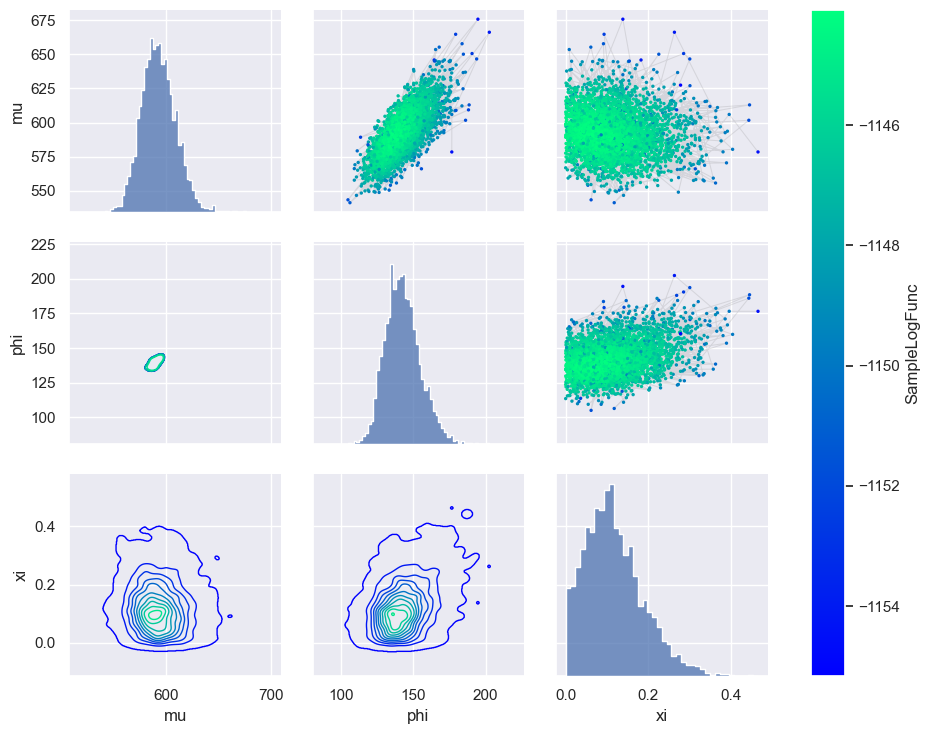

In [54]:
sample_tide.plot.grid.plotType.upper.enabled = True # disable upper triangle
sample_tide.plot.grid.plotType.lower.value = "contour" # let lower triangle be lineScatter plot
sample_tide.plot.grid(columns = [1,2,3]) # make grid plot of all parameters
# sample_tide.plot.grid.addTarget() # add the maximum-likelihood set of parameters as the target value to all plots

plt.savefig("MM_MCMC_ParamValues", bbox_inches = 'tight', dpi = 300)


In [55]:
sample_tide.df

,SampleLogFunc,mu,phi,xi
0,-1154.5938,578.43000,176.55834,0.464719
1,-1149.9439,605.93572,176.57626,0.395100
2,-1147.7888,580.58755,150.45975,0.326813
3,-1148.9003,582.43738,143.02805,0.324947
4,-1147.7550,582.35560,156.70297,0.265239
...,...,...,...,...
4078,-1144.7797,609.83193,148.09737,0.051728
4079,-1145.6249,586.61829,141.42650,0.009053
4080,-1148.9432,565.67131,126.54108,0.276690
4081,-1145.9022,620.66221,154.92033,0.023944


In [56]:
z = []
for i in range(434, 5000):
    z.append(i) 
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append (x) # water heights to calculate return periods for

param_num = []
for x in range(0, len(sample_tide.df)):
    param_num.append(x)

def n_z_tide (z):
    
    mcmc_curves_tide = []
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    
    for i in range(0, 1000):
        
        expected_per_z = []
        
        for j in range(0, len(water_height_nums)):
            
            # optimized parameter values
            mu = sample_tide.df.loc[i, 'mu']
            phi = sample_tide.df.loc[i, 'phi']
            xi = sample_tide.df.loc[i, 'xi']
            
            c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
            expected_per_z.append(c)
            
        plt.plot(z, expected_per_z, color = 'lightgray')         
    
    plt.scatter(testexcb, exceeded_tide, facecolors = 'none', edgecolors = 'cyan', label = 'Empirical Exceedances', zorder = 10000)
    
#     plt.plot(testexca, trueexc, color = 'slategray')
    ax.set_yscale('log')
    ax.set_ylim([1e-3, 1e1])
    ax.set_xlim([434, 3000])
    plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
    plt.ylabel('True Expected Exceedances/Year', fontsize = 12)
    plt.legend(loc = "upper right")
    
    plt.savefig("MM_MCMC_Curves", bbox_inches = 'tight', dpi = 300)
    
    return ()


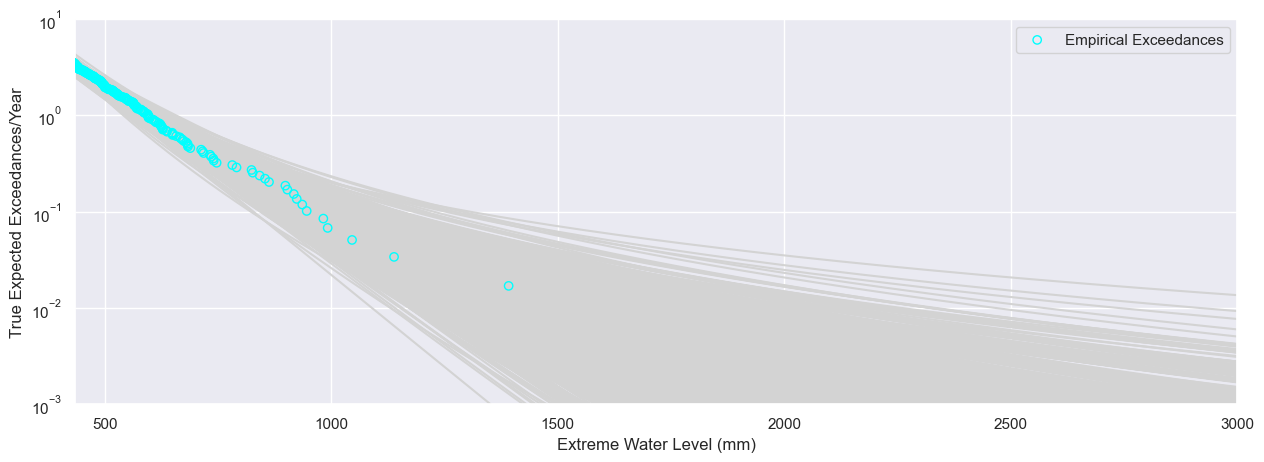

In [57]:
mcmc_curves_tide = n_z_tide(z)

In [58]:
pmpd_geo = pm.ParaDRAM()

In [59]:
pmpd_geo.spec.overwriteRequested = True # overwrite the existing output files just in case they already exist.
pmpd_geo.spec.outputFileName = "./out/ESL&GS_S_MCMC" # specify the output file prefixes.
pmpd_geo.spec.randomSeed = 12345 # set the random seed for the sake of reproducibity.
pmpd_geo.spec.variableNameList = ["mu", "phi", "xi", "tau"] # set the output names of the parameters.
pmpd_geo.spec.chainSize = 20000 # set the number of uniquely sampled points from the likelihood function.
pmpd_geo.spec.domainLowerLimitVec = [400, 100, 1e-10, 1065]
pmpd_geo.spec.domainUpperLimitVec = [1000, 500, 1, 1400] 

In [60]:
pmpd_geo.runSampler( ndim = 4, # the number of parameters
               getLogFunc = log_likelihood # the objective function to sample points from
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.

 
************************************************************************************************************************************
************************************************************************************************************************************
****                                                                                                                            ****
****                                                                                                                            ****
****                                                         ParaMonte                    

                                     20000 / 84544             0.3127 / 0.2372             1.2581 / 0.0000 
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the Markov chain...
 
 
 
        ParaDRAM - NOTE: Computing the final decorrelated sample size...
 
 
 
        ParaDRAM - NOTE: Generating the output sample file:
        ParaDRAM - NOTE: ./out/ESL&GS_S_MCMC_process_1_sample.txt
 
 
 
        ParaDRAM - NOTE: Computing the statistical properties of the final refined sample...
 
 
 
 
 
        ParaDRAM - NOTE: Mission Accomplished.
 
 
 
 

ParaDRAM - WARNING: Failed to properly close the ParaMonte shared library file. 
ParaDRAM - WARNING: This should not cause any major problems, unless you intend to 
ParaDRAM - WARNING: run a new ParaMonte simulation, in which case, you may want to 
ParaDRAM - WARNING: exit and re-enter your Python environment.


ParaDRAM - NOTE: To read the generated output files, try:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     pmpd.readRepor

In [61]:
chain_geo = pmpd_geo.readChain(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readChain()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the chain file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_MCMC*_chain.txt"


ParaDRAM - NOTE: processing chain file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_MCMC_process_1_chain.txt
ParaDRAM - NOTE: reading the file contents... done in 0.021798 seconds.
ParaDRAM - NOTE: ndim = 4, count = 20000
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating a h

In [62]:
sample_geo = pmpd_geo.readSample(renabled = True)[0]


ParaDRAM - WARNING: The ``delimiter`` is neither given as input to ``readSample()``
ParaDRAM - WARNING: nor set as a simulation specification of the ParaDRAM object. 
ParaDRAM - WARNING: This information is essential, otherwise how could the output files be parsed?
ParaDRAM - WARNING: For now, the ParaDRAM sampler will assume a comma-separated 
ParaDRAM - WARNING: file format for the contents of the sample file(s) to be parsed.


ParaDRAM - NOTE: 1 files detected matching the pattern: "./out/ESL&GS_S_MCMC*_sample.txt"


ParaDRAM - NOTE: processing sample file: /Users/kristenjoyse/Library/CloudStorage/OneDrive-Personal/Code/Extreme SL & Geologic Storms/out/ESL&GS_S_MCMC_process_1_sample.txt
ParaDRAM - NOTE: reading the file contents... done in 0.002274 seconds.
ParaDRAM - NOTE: ndim = 4, count = 2029
ParaDRAM - NOTE: parsing file contents... 
ParaDRAM - NOTE: computing the sample correlation matrix... 
ParaDRAM - NOTE: adding the correlation graphics tools... 
ParaDRAM - NOTE: creating

In [63]:
sample_geo.df.mean()

SampleLogFunc   -1301.720099
mu                588.549337
phi               137.155292
xi                  0.084558
tau              1279.350479
dtype: float64

In [64]:
sample_geo.df.std()

SampleLogFunc     1.189881
mu               14.698555
phi               8.830024
xi                0.042021
tau              67.792157
dtype: float64

In [65]:
sample_geo.df.quantile([0.05, 0.5, 0.95])

,SampleLogFunc,mu,phi,xi,tau
0.05,-1304.03648,564.649626,123.222672,0.017575,1158.07224
0.50,-1301.39850,588.273240,136.945270,0.083657,1285.61100
0.95,-1300.44362,612.544378,151.847048,0.155862,1382.48106


ParaDRAM - NOTE: making the grid plot... 
generating subplot #1: (0,0) out of 16... done in 0.016634 seconds.
generating subplot #2: (0,1) out of 16... done in 0.169156 seconds.
generating subplot #3: (0,2) out of 16... done in 0.166455 seconds.
generating subplot #4: (0,3) out of 16... done in 0.161761 seconds.
generating subplot #5: (1,0) out of 16... done in 0.239792 seconds.
generating subplot #6: (1,1) out of 16... done in 0.016634 seconds.
generating subplot #7: (1,2) out of 16... done in 0.168994 seconds.
generating subplot #8: (1,3) out of 16... done in 0.168357 seconds.
generating subplot #9: (2,0) out of 16... done in 0.251494 seconds.
generating subplot #10: (2,1) out of 16... done in 0.259055 seconds.
generating subplot #11: (2,2) out of 16... done in 0.016634 seconds.
generating subplot #12: (2,3) out of 16... done in 0.169221 seconds.
generating subplot #13: (3,0) out of 16... done in 0.235295 seconds.
generating subplot #14: (3,1) out of 16... done in 0.229063 seconds.
g

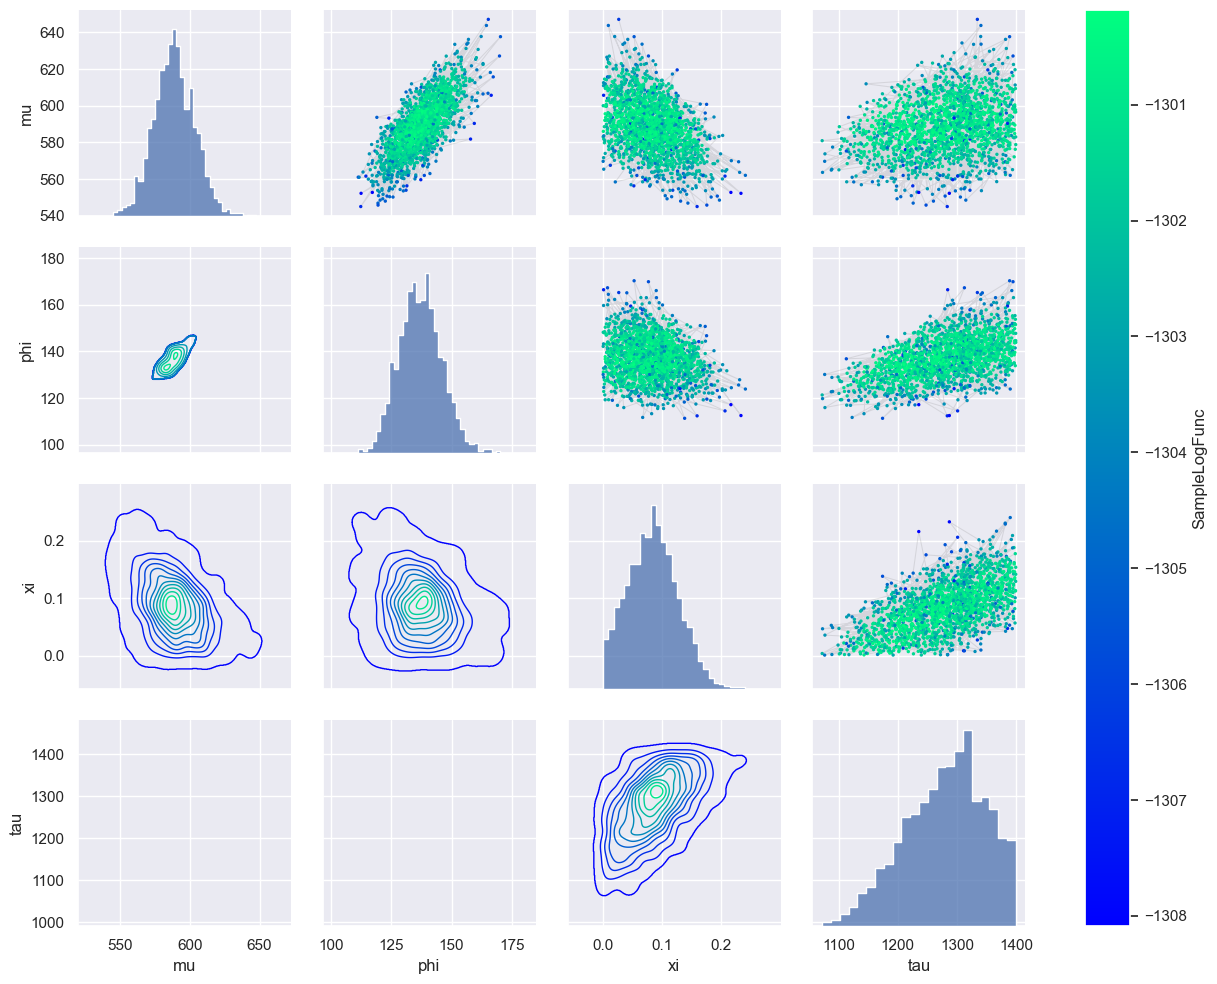

In [66]:
sample_geo.plot.grid.plotType.upper.enabled = True # disable upper triangle
sample_geo.plot.grid.plotType.lower.value = "contour" # let lower triangle be lineScatter plot
sample_geo.plot.grid(columns = [1,2,3,4]) # make grid plot of all parameters
# sample_geo.plot.grid.addTarget() # add the maximum-likelihood set of parameters as the target value to all plots

plt.savefig("MM_MCMC_ParamsGeo", bbox_inches = 'tight', dpi = 300)


In [67]:
sample_geo.df

,SampleLogFunc,mu,phi,xi,tau
0,-1306.2890,647.11699,165.22715,0.027060,1334.8017
1,-1301.1760,611.88454,147.01072,0.056742,1329.2758
2,-1301.3145,596.76333,149.76640,0.064378,1316.6421
3,-1303.3925,615.08222,155.79460,0.079551,1321.2363
4,-1300.5152,593.96831,138.99949,0.110828,1328.8376
...,...,...,...,...,...
2024,-1300.4675,596.11937,141.43570,0.081693,1329.0698
2025,-1301.4074,581.85216,143.25551,0.099659,1335.6332
2026,-1302.2008,581.36610,129.63661,0.114503,1348.4587
2027,-1300.6201,585.79334,134.94856,0.084492,1236.8572


In [68]:
print(len(sample_geo.df))

2029


In [69]:
z = []
for i in range(515, 5000):
    z.append(i) 
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append (x) # water heights to calculate return periods for

param_num = []
for x in range(0, len(sample_geo.df)):
    param_num.append(x)

def n_z_geo (z):
    
    mcmc_curves_tide = []
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    
    for i in range(0, len(param_num)):
        
        expected_per_z = []
        
        for j in range(0, len(water_height_nums)):
            
            # optimized parameter values
            mu = sample_geo.df.loc[i, 'mu']
            phi = sample_geo.df.loc[i, 'phi']
            xi = sample_geo.df.loc[i, 'xi']
            
            c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
            expected_per_z.append(c)
            
        plt.plot(z, expected_per_z, color = 'lightgray')         
    
    plt.scatter(testexcb, exceeded_tide, facecolors = 'none', edgecolors = 'cyan', label = 'Empirical Exceedances', zorder = 10000)

    ax.set_yscale('log')
    ax.set_ylim([1e-3, 1e2])
    ax.set_xlim([0, 3000])
    plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
    plt.ylabel('True Expected Exceedances/Year', fontsize = 12)
    plt.legend(loc = "upper right")
    
    plt.savefig("MM_MCMC_RunsGeo", bbox_inches = 'tight', dpi = 300)

    
    return ()


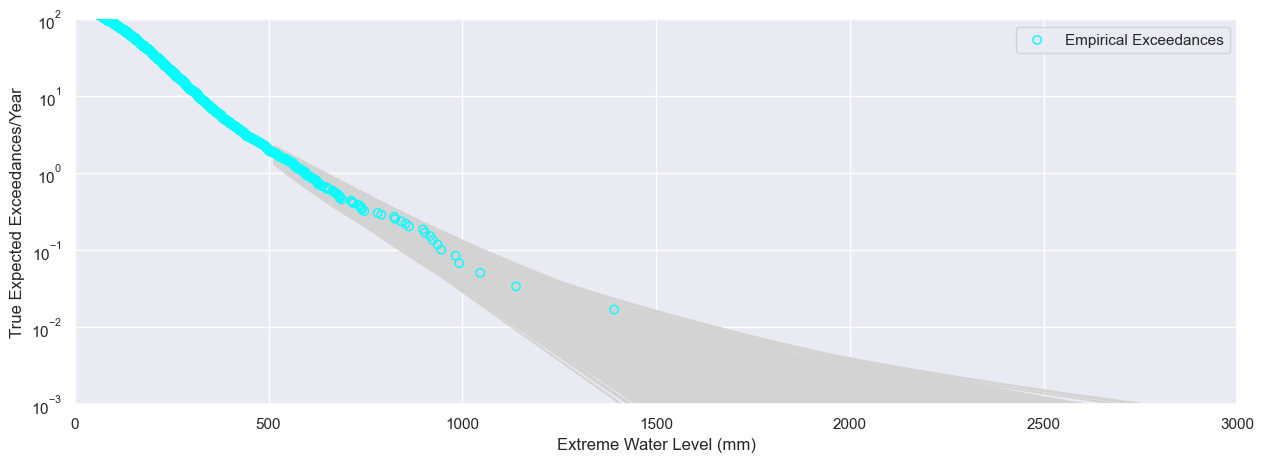

In [70]:
mcmc_curves_geo = n_z_geo(z)

In [71]:
params = pd.read_excel("syndataparams2.xlsx", sheet_name = 'MM')
params.head()

,Unnamed: 0,mu5,mu50,mu95,phi5,phi50,phi95,xi5,xi50,xi95,color
0,tide,566.4,592.0,621.2,124.5,142.1,164,0.020,0.110,0.250,lightsteelblue
1,geo,564.1,589.7,615.1,122.5,137.7,154,0.010,0.080,0.160,slategray
2,geo1_higherThreshold,569.0,592.8,623.2,128.9,142.6,158,0.045,0.106,0.171,red


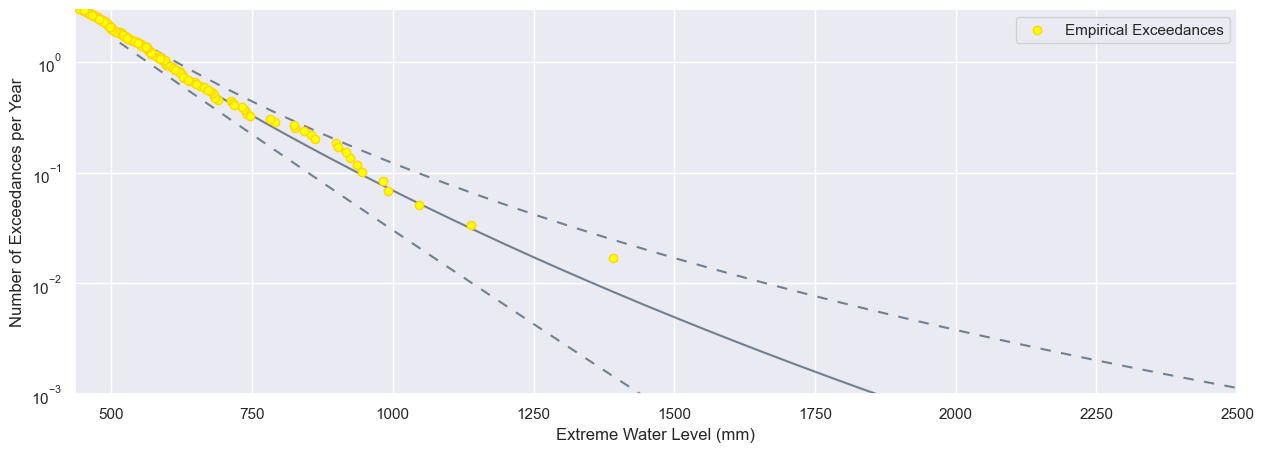

In [74]:
z = []
for i in range(515, 5000):
    z.append(i) 
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append (x) # water heights to calculate return periods for
    
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(1, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu50']
        phi = params.loc[i, 'phi50']
        xi = params.loc[i, 'xi50']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
        
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color)
    expected_per_z = pd.DataFrame(list(zip(z, expected_per_z)), columns = ['z', '50'])
    expected_per_z.to_csv("WHMM_MCMCexpectedperz50")
    
for i in range(1, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu5']
        phi = params.loc[i, 'phi5']
        xi = params.loc[i, 'xi5']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color, linestyle = (0, (5,5)))
    expected_per_z = pd.DataFrame(list(zip(z, expected_per_z)), columns = ['z', '5'])
    expected_per_z.to_csv("WHMM_MCMCexpectedperz5")
    
for i in range(1, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu95']
        phi = params.loc[i, 'phi95']
        xi = params.loc[i, 'xi95']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color, linestyle = (0, (5,5)))
    expected_per_z = pd.DataFrame(list(zip(z, expected_per_z)), columns = ['z', '95'])
    expected_per_z.to_csv("WHMM_MCMCexpectedperz95")
    
# plt.plot(testz, testlogNexc, color = 'gray', label = 'True Return Curve')
plt.scatter(testexcb, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Exceedances', zorder = 10000)

ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([435, 2500])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")

plt.savefig("MM_MCMC.pdf", bbox_inches = 'tight', dpi = 300)

    


In [ ]:
# CREATE MULTIPLE DATASETS VIA BOOTSTRAPPING

bs_q99 = []
bs_wh_tg_h99 = []

for _ in range(1000):
    x = np.random.choice(wh_tg_h, size = len(wh_tg_h), replace = True)
    y = np.quantile(wh_tg_h, 0.99)
    z = x[(x >= y)]
    bs_wh_tg_h99.append(z)
    bs_q99.append(y)


In [ ]:
# MAXIMUM LIKELIHOOD ESTIMATION

def function_a(z, parameters): # just a funciton used in both likelihood functions
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    
    return (np.log(1 + (xi * ((z - mu)/phi))))

# negative log likelihood for tide data & proxy data    
def negative_log_likelihood(parameters, q99, num_od, wh_tg_h99):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tau = parameters[3]
    tide_threshold = q99 # same as true location parameter
    
    tg_z = wh_tg_h99 # tide gauge water levels from WH
    N = len(tg_z) # number of tide gauge water levels over tide_threshold
    M = num_od # number of overwash deposits in geologic record at MM

    t1 = -50
    t2 = 2018
    t_tide = 1957
    
    nll_geo_tide = ((N * np.log(phi)) + ((1 + (1/xi)) * np.sum(function_a(tg_z, parameters))) +
        ((M/xi) * np.log(1 + (xi * ((tau - mu)/phi)))) +
        ((t2 - t_tide) * (1 + ((xi * (q99 - mu))/phi))**(-1/xi)) +
        ((t_tide - t1) * (1 + ((xi * (tau - mu))/phi))**(-1/xi)))
    
    return(nll_geo_tide) 

# negative log likelihood for tide data only
def negative_log_likelihood_tide(parameters, q99, wh_tg_h99):
    
    mu = parameters[0]
    phi = parameters[1]
    xi = parameters[2]
    tide_threshold = q99 # same as true location parameter
    
    tg_z = wh_tg_h99
    N = len(tg_z)
    
    t2 = 2018
    t_tide = 1957 # start of tide gauge record
    
    nll_tide = ((N * np.log(phi)) +
        ((1 + (1/xi)) * np.sum(function_a(tg_z, parameters))) +
        ((t2 - t_tide) * (1 + ((xi * (q99 - mu))/phi))**(-1/xi)))
    
    return(nll_tide)



In [ ]:
parametersb = [600, 120.0, 0.1, 1500]
parametersa = [600, 120.0, 0.1]

# test negative log likelihood function - testing with true parameter values
ans = negative_log_likelihood(parametersb, q99, num_od, wh_tg_h99)
print(ans)

ans1 = negative_log_likelihood_tide(parametersa, q99, wh_tg_h99)
print(ans1)

In [ ]:
# MAXIMUM LIKELIHOOD ESTIMATES

# create single MLE
parametersa0 = [700, 200, 0.2] # starting values for optimization
parametersb0 = [700, 200, 0.2, 1400]

bndsa = ((-1000, 1000), (1, 800), (1e-3, 1))
bndsb = ((-1000, 1000), (1, 800), (1e-3, 1), (0,3000))

#result = scipy.optimize.minimize(negative_log_likelihood, parameters, method = 'Nelder-Mead')
result = scipy.optimize.minimize(negative_log_likelihood, parametersb0, args = (q99, num_od, wh_tg_h99), method = 'Powell', bounds = bndsb)
print(result)
#result1 = scipy.optimize.minimize(negative_log_likelihood_tide, parameters, method = 'Nelder-Mead')
result1 = scipy.optimize.minimize(negative_log_likelihood_tide, parametersa0, args = (q99, wh_tg_h99), method = 'Powell', bounds = bndsa)
print(result1)

In [ ]:
# CREATE MULTIPLE MLEs

def list_of_mles():
    
    mles = []            
    for i in range (0, num_its):
        bnds = ((0, 800), (1, 500), (1e-3, 1), (0,3000))
        b = scipy.optimize.minimize(negative_log_likelihood, parametersb0, args = (bs_q99[i], num_od, bs_wh_tg_h99[i]), method = 'Powell', bounds = bnds)
        mles.append(b)
            
    return(mles)
    
def list_of_mles_tide():
    
    mles_tide = []
    for i in range (0,num_its):
        bnds = ((-1000, 1000), (1, 800), (1e-3, 1))
        b = scipy.optimize.minimize(negative_log_likelihood_tide, parametersa0, args = (bs_q99[i], bs_wh_tg_h99[i]), method = 'Powell', bounds = bnds)
        mles_tide.append(b)
        
    return(mles_tide)



In [ ]:
# LIST OF MLEs

num_its = 1000

mles = list_of_mles()
mles_tide = list_of_mles_tide()


In [ ]:
# PARAMETER ESTIMATES

mle_estimates = pd.DataFrame(mles)
parameter_estimates = mle_estimates['x']
parameter_estimates = parameter_estimates.tolist()
mus = [i[0] for i in parameter_estimates]
phis = [i[1] for i in parameter_estimates]
xis = [i[2] for i in parameter_estimates]
Ms = [i[3] for i in parameter_estimates]
parameter_estimates = pd.DataFrame(list(zip(mus, phis, xis, Ms)), columns = ['Mu', 'Phi', 'Xi', 'M'])

table_tide_parameters = parameter_estimates.describe(percentiles = [0.05, 0.50, 0.95])
table_tide_parameters.to_csv('TideParameterStats_WHMM_StationaryCase')

mle_estimates_tide = pd.DataFrame(mles_tide)
parameter_estimates_tide = mle_estimates_tide['x']
parameter_estimates_tide = parameter_estimates_tide.tolist()
mus_tide = [i[0] for i in parameter_estimates_tide]
phis_tide = [i[1] for i in parameter_estimates_tide]
xis_tide = [i[2] for i in parameter_estimates_tide]
parameter_estimates_tide = pd.DataFrame(list(zip(mus_tide, phis_tide, xis_tide)), columns = ['Mu', 'Phi', 'Xi'])

table_tide_parameters = parameter_estimates_tide.describe(percentiles = [0.05, 0.50, 0.95])
table_tide_parameters.to_csv('TideParameterStats_WH_StationaryCase')


In [ ]:
# MODEL OUTPUTS FROM TG DATA ALONE 

testexca = list(np.arange(400, 3000, 1))

water_height_nums = []
for x in range(0, len(testexca)):
    water_height_nums.append (x)

param_num = []
for x in range(0, len(parameter_estimates_tide)):
    param_num.append(x)

# return values estimated by observable tide gauge data alone
def n_z_tide (z, parameter_estimates_tide):
    
    expected_annual_events_tide = []
    
    for i in range(0, len(water_height_nums)):
        expected_per_z = []
        for j in range(0, len(param_num)):
            
            # optimized parameter values
            mu = parameter_estimates_tide.loc[j, 'Mu']
            phi = parameter_estimates_tide.loc[j, 'Phi']
            xi = parameter_estimates_tide.loc[j, 'Xi']
            
            c = ((1 + (xi * (z[i] - mu)/phi))**(-1/xi))
            expected_per_z.append(c)
            
        expected_per_z = pd.DataFrame(expected_per_z)
        d = expected_per_z.quantile([0.05, 0.5, 0.95])
        d = d.values.tolist()
        expected_annual_events_tide.append(d)
            
    return (expected_annual_events_tide)
    

In [ ]:
expected_annual_events_tide = n_z_tide(testexca, parameter_estimates_tide)
expected_annual_events_tide = pd.DataFrame(expected_annual_events_tide)

In [ ]:
# MODEL OUTPUT FROM TIDE GAUGE AND GEOLOGIC DATA

water_height_nums = []
for x in range(0, len(testexca)):
    water_height_nums.append (x)

param_num = []
for x in range(0, len(parameter_estimates)):
    param_num.append(x)

def n_z_geologic (z, parameter_estimates):
    
    expected_annual_events_geologic = []
    
    for i in range(0, len(water_height_nums)):
        expected_per_z = []
        for j in range(0, len(param_num)):
            
            # optimized parameters
            mu = parameter_estimates.loc[j, 'Mu']
            phi = parameter_estimates.loc[j, 'Phi']
            xi = parameter_estimates.loc[j, 'Xi']
            
            c = ((1 + (xi * (z[i]- mu)/phi))**(-1/xi))
            expected_per_z.append(c)
            
        expected_per_z = pd.DataFrame(expected_per_z)
        d = expected_per_z.quantile([0.05, 0.5, 0.95])
        d = d.values.tolist()
        expected_annual_events_geologic.append(d)
        
    return(expected_annual_events_geologic)

In [ ]:
expected_annual_events_geologic = n_z_geologic(testexca, parameter_estimates)
expected_annual_events_geologic = pd.DataFrame(expected_annual_events_geologic)

In [ ]:
# return curves from modeled parameter values
d_50_tide = expected_annual_events_tide.loc[:, 1]
d_50_tide = d_50_tide.tolist()
d_50_tidepd = pd.DataFrame(list(zip(testexca, d_50_tide)), columns = ['z', 'd_50'])
d_50_tidepd.to_csv('wh_d_50')
d_5_tide = expected_annual_events_tide.loc[:, 0]
d_5_tide = d_5_tide.tolist()
d_5_tidepd = pd.DataFrame(list(zip(testexca, d_5_tide)), columns = ['z', 'd_5'])
d_5_tidepd.to_csv('wh_d_5')
d_95_tide = expected_annual_events_tide.loc[:, 2]
d_95_tide = d_95_tide.tolist()
d_95_tidepd = pd.DataFrame(list(zip(testexca, d_95_tide)), columns = ['z', 'd_95'])
d_95_tidepd.to_csv('wh_d_95')

d_50_geo = expected_annual_events_geologic.loc[:, 1]
d_50_geo = d_50_geo.tolist()
d_50_geopd = pd.DataFrame(list(zip(testexca, d_50_geo)), columns = ['z', 'd_50'])
d_50_geopd.to_csv('whmm_d_50')
d_5_geo = expected_annual_events_geologic.loc[:, 0]
d_5_geo = d_5_geo.tolist()
d_5_geopd = pd.DataFrame(list(zip(testexca, d_5_geo)), columns = ['z', 'd_5'])
d_5_geopd.to_csv('whmm_d_5')
d_95_geo = expected_annual_events_geologic.loc[:, 2]
d_95_geo = d_95_geo.tolist()
d_95_geopd = pd.DataFrame(list(zip(testexca, d_95_geo)), columns = ['z', 'd_95'])
d_95_geopd.to_csv('whmm_d_95')

In [ ]:
# plot true return curve against modeled curve using tide gauge data only
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
# plt.plot(testexca, trueexc, color = 'slategray', label = 'Student t Distribution')
plt.scatter(testexcb, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Tide Gauge Observations', zorder = 10)
plt.plot(testexca, d_50_tide, color = "lightcoral", label = 'Tide Gauge Data')
plt.plot(testexca, d_5_tide, linestyle = (0, (5,5)), color = "lightcoral")
plt.plot(testexca, d_95_tide, linestyle = (0, (5,5)), color = "lightcoral")
plt.plot(testexca, d_50_geo, color = "rosybrown", label = "Tide Gauge & Geologic Data with Modeled Geologic Threshold")
plt.plot(testexca, d_5_geo, linestyle = (0, (5,5)), color = "rosybrown")
plt.plot(testexca, d_95_geo, linestyle = (0, (5,5)), color = "rosybrown")
ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([435, 2500])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Expected Exceedances/Year', fontsize = 12)
plt.legend()

plt.savefig("MM&WHReturnCurves_Stationary_bootstrap.pdf", bbox_inches = 'tight', dpi = 300)



In [ ]:
# MCMC ESTIMATES

z = []
for i in range(515, 5000):
    z.append(i) 
    
water_height_nums = []
for x in range(0, len(z)):
    water_height_nums.append (x) # water heights to calculate return periods for
    
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(0, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu50']
        phi = params.loc[i, 'phi50']
        xi = params.loc[i, 'xi50']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color)
    
for i in range(0, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu5']
        phi = params.loc[i, 'phi5']
        xi = params.loc[i, 'xi5']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color, linestyle = (0, (5,5)))
    
for i in range(0, 2):
    
    expected_per_z = []

    for j in range(0, len(water_height_nums)):
            
        mu = params.loc[i, 'mu95']
        phi = params.loc[i, 'phi95']
        xi = params.loc[i, 'xi95']
            
        c = ((1 + (xi * (z[j] - mu)/phi))**(-1/xi))
        expected_per_z.append(c)
    
    color = params.loc[i, 'color']
    plt.plot(z, expected_per_z, color = color, linestyle = (0, (5,5))) 
    
# plt.plot(testz, testlogNexc, color = 'gray', label = 'True Return Curve')
plt.scatter(testexcb, exceeded_tide, facecolors = 'yellow', edgecolors = 'gold', label = 'Empirical Exceedances', zorder = 100)

#MLE ESTIMATES
# plt.plot(testexca, d_50_tide, color = "lightcoral", label = 'Tide Gauge Data')
# plt.plot(testexca, d_5_tide, linestyle = (0, (5,5)), color = "lightcoral")
# plt.plot(testexca, d_95_tide, linestyle = (0, (5,5)), color = "lightcoral")
# plt.plot(testexca, d_50_geo, color = "rosybrown", label = "Tide Gauge & Geologic Data with Modeled Geologic Threshold")
# plt.plot(testexca, d_5_geo, linestyle = (0, (5,5)), color = "rosybrown")
# plt.plot(testexca, d_95_geo, linestyle = (0, (5,5)), color = "rosybrown")

ax.set_yscale('log')
ax.set_ylim([1e-3, 3])
ax.set_xlim([435, 2500])
plt.xlabel('Extreme Water Level (mm)', fontsize = 12)
plt.ylabel('Number of Exceedances per Year', fontsize = 12)
plt.legend(loc = "upper right")

plt.savefig("MM_MCMC.pdf", bbox_inches = 'tight', dpi = 300)

    
